# PoseNet for Self-Localization on Apolloscape Dataset

In [17]:
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import clear_output

import numpy as np

import torch
from torch import nn
from torchvision import transforms, models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchviz import make_dot

from datasets.apolloscape import Apolloscape

from utils.common import draw_poses
from utils.common import draw_record
from utils.common import imshow
from utils.common import save_checkpoint
from utils.common import AverageMeter
from utils.common import calc_poses_params

from models.posenet import PoseNet, PoseNetCriterion

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image

from tqdm import tqdm
import os
import time
from datetime import datetime

%matplotlib inline
plt.ion()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Apolloscape Dataset

In [2]:
APOLLO_PATH = "./data/apolloscape"

# Resize data before using
transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(250),
    transforms.ToTensor()
])


train_record = 'Record001'
train_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=train_record, normalize_poses=True,
                             pose_format='quat', train=True, cache_transform=True)

val_record = 'Record011'
val_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=val_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True)

test_record = 'Record013'
test_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=test_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True)



print(train_dataset)
print(val_dataset)
print(test_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=8) # batch_size = 75
val_dataloader = DataLoader(val_dataset, batch_size=8) # batch_size = 75
test_dataloader = DataLoader(test_dataset, batch_size=8) # batch_size = 75


Dataset: Apolloscape
    Road: zpark-sample
    Record: Record001
    Train: True
    Normalize Poses: True
    Length: 121 of 1121
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']

Dataset: Apolloscape
    Road: zpark-sample
    Record: Record011
    Train: False
    Normalize Poses: True
    Length: 87 of 378
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']

Dataset: Apolloscape
    Road: zpark-sample
    Record: Record013
    Train: False
    Normalize Poses: True
    Length: 120 of 378
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Reco

## Draw Train and Val datasets

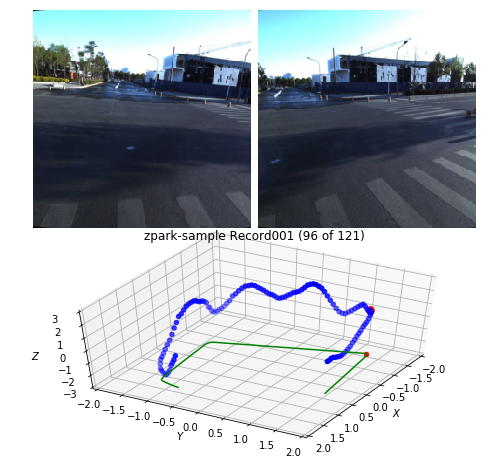

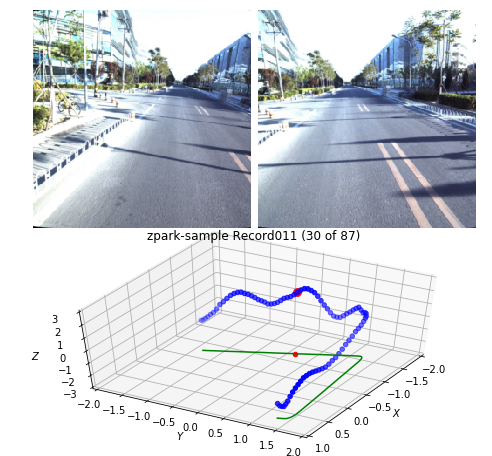

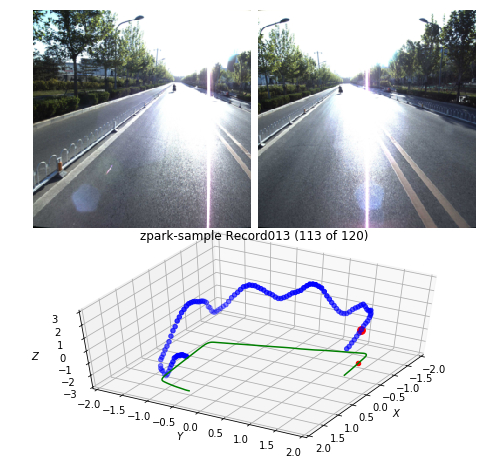

In [3]:
# Draw datasets
draw_record(train_dataset)
plt.show()

draw_record(val_dataset)
plt.show()

draw_record(test_dataset)
plt.show()

## Device set up

In [4]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('device = {}'.format(device))

device = cuda


## Train and Validate Functions

In [5]:
# train function
def train(train_loader, model, criterion, optimizer, epoch, max_epoch, log_freq=1, print_sum=True):
    
    # switch model to training
    model.train()
    
#     log_freq = 0
    
    losses = AverageMeter()
    
    end = time.time()
    for idx, (batch_images, batch_poses) in enumerate(train_loader):
#         if idx < len(train_loader) - 1: continue
        data_time = (time.time() - end)
        
        batch_images = [x.to(device) for x in batch_images]
        batch_poses = [x.to(device) for x in batch_poses]
        
        out = model(batch_images)
        loss = criterion(out, batch_poses)

        
        losses.update(loss, len(batch_images) * batch_images[0].size(0))
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch + 1, max_epoch, idx + 1, len(train_loader),
                   batch_time=batch_time, data_time=data_time, losses=losses))
            
    if print_sum:
        print('Epoch: [{}/{}]\tTraining Loss: {:.3f}'.format(epoch+1, max_epoch, losses.avg))
        
    return losses.avg
    
    
def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True):
    
#     log_freq = 0 # len(val_loader)
    
    losses = AverageMeter()
    
    # set model to evaluation
    model.eval()
    
    with torch.no_grad():
        end = time.time()
        for idx, (batch_images, batch_poses) in enumerate(val_loader):
            data_time = time.time() - end
            batch_images = [x.to(device) for x in batch_images]
            batch_poses = [x.to(device) for x in batch_poses]
            
            # compute model output
            out = model(batch_images)
            loss = criterion(out, batch_poses)
            
            losses.update(loss, len(batch_images) * batch_images[0].size(0))
            
            batch_time = time.time() - end
            end = time.time()
            
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch + 1, batch_time=batch_time, data_time=data_time, losses=losses))
                
    
    if print_sum:
        print('Epoch: [{}]\tValidation Loss: {:.3f}'.format(epoch+1, losses.avg))
        
    return losses.avg


## Create Model, Criterion and Optimizer

In [6]:
# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)

# Create model
model = PoseNet(feature_extractor)
model = model.to(device)

# Criterion
criterion = PoseNetCriterion()

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)


## Restore from Chekpoint

In [17]:
# Restore from checkpoint
checkpoint_file = '_checkpoints/20180728_130156_apollo_zpark_r001_e300.pth.tar'

if 'checkpoint_file' in locals() and checkpoint_file is not None:
    if os.path.isfile(checkpoint_file):
        print('Loading from checkpoint: {}'.format(checkpoint_file))
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        start_epoch = checkpoint['epoch']


Loading from checkpoint: _checkpoints/20180728_130156_apollo_zpark_r001_e300.pth.tar


## Run Training

In [53]:
if 'start_epoch' not in locals():
    start_epoch = 0

n_epochs = start_epoch + 400
print('Training ...')
val_freq = 5
for e in range(start_epoch, n_epochs):

    end = time.time()
    train(train_dataloader, model, criterion, optimizer, e, n_epochs, log_freq=0)
#     print('Train epoch time: {:.3f}'.format(time.time() - end))
    
#     print('Validation ...')
    if e & val_freq == 0:
        end = time.time()
        validate(val_dataloader, model, criterion, e, log_freq=0)
#     print('Validation epoch time: {:.3f}'.format(time.time() - end))

#     print('Test dataset ...')
#     validate(test_dataloader, model, criterion, e, log_freq=0)


Training ...
Epoch: [1/400]	Training Loss: 0.724
Epoch: [1]	Validation Loss: 1.905
Epoch: [2/400]	Training Loss: 0.471
Epoch: [3/400]	Training Loss: 0.366
Epoch: [3]	Validation Loss: 1.679
Epoch: [4/400]	Training Loss: 0.262
Epoch: [5/400]	Training Loss: 0.235
Epoch: [6/400]	Training Loss: 0.196
Epoch: [7/400]	Training Loss: 0.242
Epoch: [8/400]	Training Loss: 0.235
Epoch: [9/400]	Training Loss: 0.242
Epoch: [9]	Validation Loss: 1.618
Epoch: [10/400]	Training Loss: 0.210
Epoch: [11/400]	Training Loss: 0.245
Epoch: [11]	Validation Loss: 1.610
Epoch: [12/400]	Training Loss: 0.174
Epoch: [13/400]	Training Loss: 0.170
Epoch: [14/400]	Training Loss: 0.184
Epoch: [15/400]	Training Loss: 0.191
Epoch: [16/400]	Training Loss: 0.196
Epoch: [17/400]	Training Loss: 0.195
Epoch: [17]	Validation Loss: 1.608
Epoch: [18/400]	Training Loss: 0.205
Epoch: [19/400]	Training Loss: 0.174
Epoch: [19]	Validation Loss: 1.655
Epoch: [20/400]	Training Loss: 0.172
Epoch: [21/400]	Training Loss: 0.159
Epoch: [22/4

Epoch: [237/400]	Training Loss: 0.141
Epoch: [238/400]	Training Loss: 0.152
Epoch: [239/400]	Training Loss: 0.139
Epoch: [240/400]	Training Loss: 0.183
Epoch: [241/400]	Training Loss: 0.177
Epoch: [241]	Validation Loss: 1.730
Epoch: [242/400]	Training Loss: 0.146
Epoch: [243/400]	Training Loss: 0.144
Epoch: [243]	Validation Loss: 1.722
Epoch: [244/400]	Training Loss: 0.164
Epoch: [245/400]	Training Loss: 0.153
Epoch: [246/400]	Training Loss: 0.143
Epoch: [247/400]	Training Loss: 0.146
Epoch: [248/400]	Training Loss: 0.194
Epoch: [249/400]	Training Loss: 0.173
Epoch: [249]	Validation Loss: 1.713
Epoch: [250/400]	Training Loss: 0.170
Epoch: [251/400]	Training Loss: 0.159
Epoch: [251]	Validation Loss: 1.704
Epoch: [252/400]	Training Loss: 0.169
Epoch: [253/400]	Training Loss: 0.153
Epoch: [254/400]	Training Loss: 0.169
Epoch: [255/400]	Training Loss: 0.190
Epoch: [256/400]	Training Loss: 0.180
Epoch: [257/400]	Training Loss: 0.147
Epoch: [257]	Validation Loss: 1.729
Epoch: [258/400]	Train

In [43]:
# for param_group in optimizer.param_groups:
#     print(param_group['lr'])

## Test Model

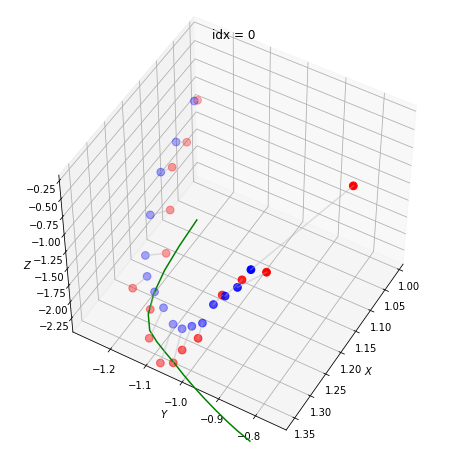

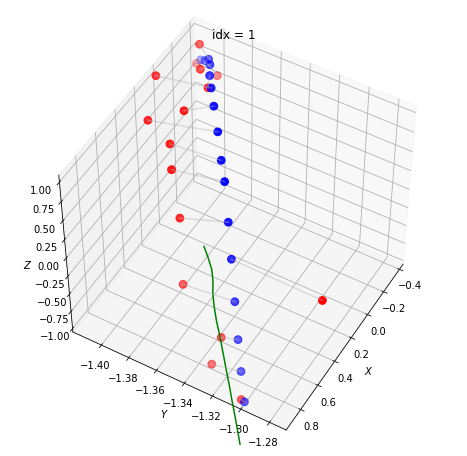

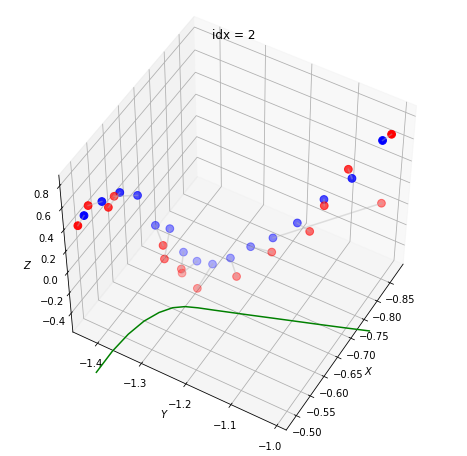

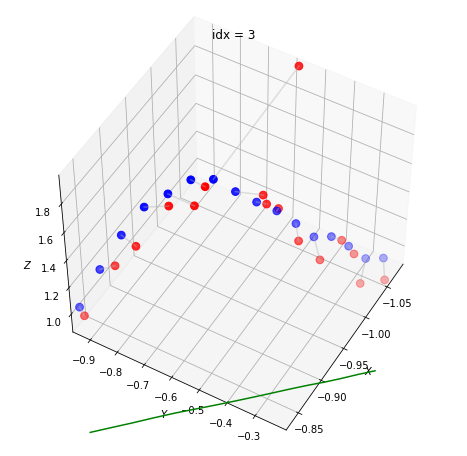

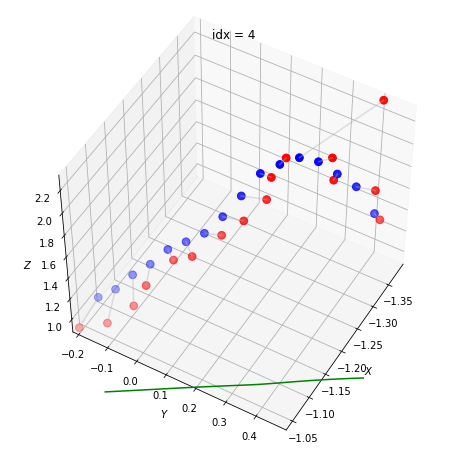

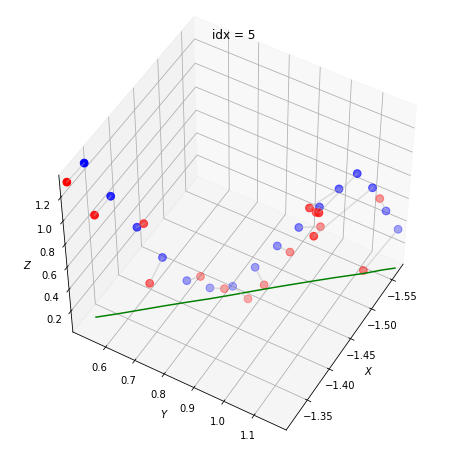

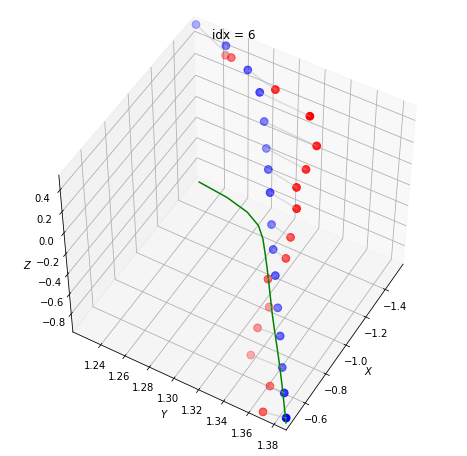

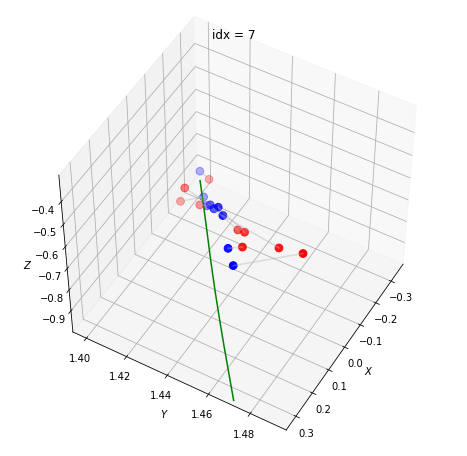

In [56]:
# Test model
# tb_images, tb_poses = next(iter(test_dataloader))
# print('tb_poses = {}'.format(tb_poses))


def set_3d_axes_limits(ax, poses, pose_format='quat'):
    p_min, p_max, p_mean, p_std = calc_poses_params(poses, pose_format=pose_format)
    ax.set_xlim(p_min[0], p_max[0])
    ax.set_ylim(p_min[1], p_max[1])
    ax.set_zlim(p_min[2], p_max[2])
    return p_min, p_max, p_mean, p_std


def draw_pred_gt_poses(pred_poses, gt_poses):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.view_init(50, 30)

    all_poses = np.concatenate((pred_poses, gt_poses))
    p_min, _, _, _ = set_3d_axes_limits(ax, all_poses, pose_format='quat')
    
    draw_poses(ax, pred_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
    draw_poses(ax, gt_poses[:, :3], proj=True, proj_z=int(p_min[2] - 1), c='b', s=60)
    for i in range(pred_poses.shape[0]):
        pp = pred_poses[i, :3]
        gp = gt_poses[i, :3]
        pps = np.vstack((pp, gp))
        ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
        
    plt.draw()


    

train_dataloader = DataLoader(train_dataset, batch_size=16)

# p_min, p_max, p_mean, p_std = train_dataset.get_poses_params(all_records=False)


# fig = plt.figure(figsize=(8, 8))
# ax = plt.axes(projection='3d')

# ax.set_xlabel('$X$')
# ax.set_ylabel('$Y$')
# ax.set_zlabel('$Z$')
# ax.view_init(50, 30)


# ax.set_xlim(int(p_min[0] - 1), int(p_max[0] + 1))
# ax.set_ylim(int(p_min[1] - 1), int(p_max[1] + 1))
# ax.set_zlim(int(p_min[2] - 1), int(p_max[2] + 1))



for idx, (tb_images, tb_poses) in enumerate(train_dataloader):
    tb_images = [x.to(device) for x in tb_images]
    output = model(tb_images)
#     print('output = {}'.format(output))

    # detach
    output = [x.cpu().detach().numpy() for x in output]
    
    draw_pred_gt_poses(output[0], tb_poses[0])
    plt.title('idx = {}'.format(idx))
    plt.show()
    
    # gt + pred poses
#     all_poses = np.concatenate((output[0][:, :3], tb_poses[0][:, :3]))
#     set_3d_axes_limits(ax, all_poses, pose_format=train_dataset.pose_format)
    
#     draw_poses(ax, output[0][:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
#     draw_poses(ax, tb_poses[0][:, :3], proj=True, proj_z=int(p_min[2] - 1), c='b', s=60)
#     for i in range(output[0].shape[0]):
#         pp = output[0][i, :3]
#         gp = tb_poses[0][i, :3]
#         pps = np.vstack((pp, gp))
#         ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
    
    if idx == 8:
        break
        
#     plt.draw()
    
    
#     ax.scatter(tb_poses[0][:, 0], tb_poses[0][:, 1], tb_poses[0][:, 2], c='r')

plt.show()

## Save Model Checkpoint

In [54]:
# Save checkpoint
save_checkpoint(model, optimizer, 'apollo_zpark_r001', n_epochs)
    

'_checkpoints/20180731_221505_apollo_zpark_r001_e400.pth.tar'